## Latent visualization: Synth data
Do the visualization of the new data and 

In [1]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var
from rnnvae import rnnvae_h
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d, plot_latent_space
import os
import math
from rnnvae.data_gen import LatentDataGeneratorCurves
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [2]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

print(DEVICE)

out_dir = "synth_final_tests/test_synth_mc_dropout4/"

#load parameters
p = eval(open(out_dir + "params.txt").read())
print(p['curves'])

# data parameters
ntp = 10
noise = 0.1
variable_tp=False
lat_dim=2
n_channels=3
n_feats=10
n_samples=200

ch_type = ["long", "long", "long"]

model = rnnvae_h.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])

model = model.to(DEVICE)
model.load(out_dir+'model.pt')

cuda:0
[('sigmoid', {'L': 1, 'k': 1, 'x0': 5}), ('sin', {'A': 1, 'f': 0.2}), ('cos', {'A': 1, 'f': 0.2})]


In [3]:
# Test reconstruction of samples
#Generate data, with different parameters
lat_gen = LatentDataGeneratorCurves(p["curves"], ch_type, ntp, noise, lat_dim, n_channels, n_feats)
Z, X = lat_gen.generate_samples(n_samples)


X_train_list = []
X_samples_notensor = []
mask_train_list = []

#generate the data, and the mask corresponding to each channel
for x_ch in X:
    #originally, x_ch is ntp, nfeat, nsamples
    #  should be size nsamples, ntp, nfeat
    #x_ch = x_ch.swapaxes(0,2).swapaxes(1,2)
    X_train_tensor = [ torch.FloatTensor(t) for t in x_ch ]
    X_train_pad_i = nn.utils.rnn.pad_sequence(X_train_tensor, batch_first=False, padding_value=np.nan)
    mask_train = ~torch.isnan(X_train_pad_i)
    mask_train_list.append(mask_train.to(DEVICE))
    X_train_pad_i[torch.isnan(X_train_pad_i)] = 0
    X_train_list.append(X_train_pad_i.to(DEVICE))
    X_samples_notensor.append(x_ch)

# Predict the reconstructions from X_val and X_train


In [4]:
X_fwd = model.predict(X_train_list, mask_train_list, nt=ntp)

#Reformulate things
X_pred = [np.array(x).swapaxes(0,1) for x in X_fwd['xnext']]

print(len(X_pred))
print(X_pred[0].shape)

print(len(X_samples_notensor))
print(len(X_samples_notensor[0]))
print(len(X_samples_notensor[0][0]))


3
(200, 10, 10)
3
200
5


In [5]:
# Predict reconstruction
ch_list = [0,1,2]

recon_ch = []

for ch in ch_list:
    av_ch = [0,1,2]
    av_ch.remove(ch)
    print(av_ch)
    # Predict the reconstructions from X_val and X_train
    X_fwd = model.predict(X_train_list, mask_train_list, nt=ntp, av_ch=av_ch, task='recon')

    #Reformulate things
    X_fwd = [np.array(x).swapaxes(0,1) for x in X_fwd['xnext']]
    recon_ch.append(X_fwd)


[1, 2]
[0, 2]
[0, 1]


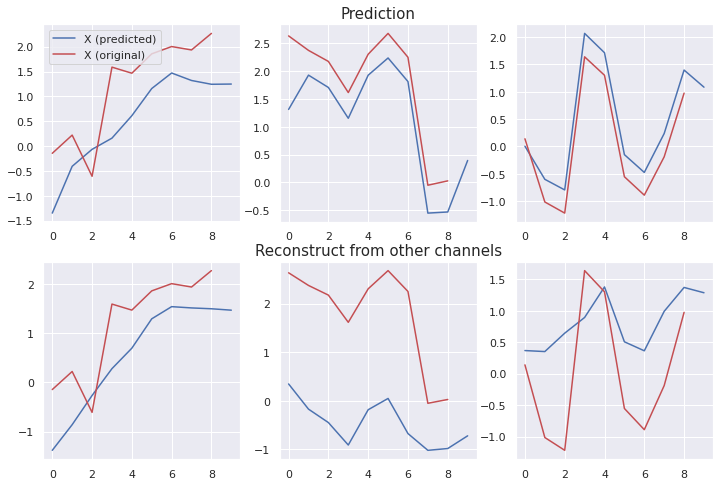

In [16]:
#candidates 57
subj = 57
feat = 2
sns.set()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,8), sharex=False, sharey=False)
## Create figures of three signals and their points, with a subplots and everything
ch_feats = [0,1,2]
axes = [ax1,ax2,ax3]
#Plot full reconstruction
for (ch, ax) in zip(ch_feats, axes):

    X_hat_line = X_pred[ch][subj][:, feat]   #Select only the subject we want
    X_samples_line = X_samples_notensor[ch][subj][:, feat]   #Select only the subject we want

    # Plot the two lines
    ax.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
    ax.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

    #ax.set_xlabel('time-point')
    #ax.xlabel("time-point")
    #ax.ylabel("value")
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

#Plot full reconstruction
axes = [ax4,ax5,ax6]
for (ch, ax) in zip(ch_feats, axes):

    X_hat_line = recon_ch[ch][ch][subj][:, feat]   #Select only the subject we want
    X_samples_line = X_samples_notensor[ch][subj][:, feat]   #Select only the subject we want

    # Plot the two lines
    ax.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
    ax.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

    #ax.set_xlabel('time-point')
    #ax.xlabel("time-point")
    #ax.ylabel("value")
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

ax1.legend(loc='upper left')
ax2.set_title("Prediction", fontsize=15)
ax5.set_title("Reconstruct from other channels",fontsize=15)
#plt.title("Predicted vs real")
# plt.show()
plt.savefig("fig_gen/synth_recon.pdf", dpi=300)

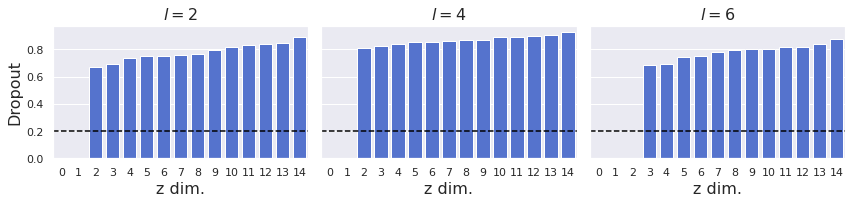

In [18]:
### Create figures for latent dropout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

#load the three models
out_dir_2lat = "synth_final_tests/test_synth_mc_dropout2/"
p = eval(open(out_dir_2lat + "params.txt").read())
model2 = rnnvae_h.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])
model2.load(out_dir_2lat+'model.pt')
dropout2 = model2.dropout_comp
                                    
#load parameters
out_dir_4lat = "synth_final_tests/test_synth_mc_dropout4/"
p = eval(open(out_dir_4lat + "params.txt").read())
model4 = rnnvae_h.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])
model4.load(out_dir_4lat+'model.pt')
dropout4 = model4.dropout_comp
                                    
#load parameters
out_dir_6lat = "synth_final_tests/test_synth_mc_dropout6/"
p = eval(open(out_dir_6lat + "params.txt").read())
model6 = rnnvae_h.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["ch_type"], p["n_feats"], DEVICE, print_every=100, 
                        phi_layers=p["phi_layers"], sigmoid_mean=p["sig_mean"],
                        dropout=p["dropout"], dropout_threshold=p["drop_th"])
model6.load(out_dir_6lat+'model.pt')
dropout6 = model6.dropout_comp

#sort the dropouts
dropout2 = np.sort(dropout2).squeeze()
dropout4 = np.sort(dropout4).squeeze()
dropout6 = np.sort(dropout6).squeeze()
# plot each
sns.barplot(x=list(range(len(dropout2))), y=dropout2, color="royalblue", ax=ax1)
sns.barplot(x=list(range(len(dropout4))), y=dropout4, color="royalblue", ax=ax2)
sns.barplot(x=list(range(len(dropout6))), y=dropout6, color="royalblue", ax=ax3)

# plot lines
ax1.axhline(0.2, ls='--', c='black')
ax2.axhline(0.2, ls='--', c='black')
ax3.axhline(0.2, ls='--', c='black')

ax1.set_ylabel("Dropout", fontsize=16)
ax1.set_xlabel("z dim.", fontsize=16)
ax2.set_xlabel("z dim.", fontsize=16)
ax3.set_xlabel("z dim.", fontsize=16)

ax1.set_title("$l=2$", fontsize=16)
ax2.set_title("$l=4$", fontsize=16)
ax3.set_title("$l=6$", fontsize=16)

plt.tight_layout()
plt.savefig("fig_gen/synthvardrop.pdf", dpi=300)
plt.show()
